In [2]:
import regex as reg 
import unicodedata  
import os, re, json, html, base64
import numpy as np
import pandas as pd
from pathlib import Path
from ftfy import fix_text
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import HTML, display
from pathlib import Path
import seaborn as sns
from matplotlib.ticker import PercentFormatter

In [3]:
DATA_DIR = Path("/workspace/data")
IMG_DIR = Path("/workspace/data/images/image_train")
X_train = pd.read_csv(DATA_DIR/"X_train_update.csv", index_col=0)
Y_train = pd.read_csv(DATA_DIR/"Y_train_CVw08PX.csv", index_col=0)

In [4]:
#X_train.info()

In [5]:
#Y_train.info()

In [6]:
# Sélectionne 5 exemples (lignes) au hasard dans X_train pour inspection.
# 'random_state=42' assure que cet échantillon aléatoire est toujours le même
X_sample = X_train.sample(5, random_state=42)
Y_sample = Y_train.sample(5, random_state=42)
#display(X_sample)

In [7]:
# Affiche toutes les lignes de X_train qui contiennent au moins une valeur manquante (NaN).
#display(X_train[X_train.isnull().any(axis=1)])

In [8]:
# Analyse des valeurs manquantes (NaN) dans X_train :
# Affiche un aperçu des lignes avec des NaN, prend un échantillon aléatoire (X et Y),
# calcule le taux de NaN global par colonne, et affiche le taux spécifique pour la colonne 'description'.
# taux manquant de description
no_description = X_train["description"].isna().mean()
print(f"Description manquante: {no_description:.2%}")

Description manquante: 35.09%


In [9]:
# taux manquant de disignation
no_designation = X_train["designation"].isna().mean()
display(f"Designation manquante: {no_designation:.2%}")

'Designation manquante: 0.00%'

In [10]:
# 1. Calculer la proportion de descriptions manquantes par catégorie ('prdtypecode')
missing_by_cat = (
    df.assign(description_isna=df["description"].isna())  # Ajoute une colonne True/False si la description est NaN
      .groupby("prdtypecode")["description_isna"]        # Regroupe par catégorie de produit
      .mean()                                            # Calcule le taux moyen de NaN (True=1, False=0)
      .reset_index(name="missing_ratio")                 # Convertit le résultat en DataFrame
)

# 2. Trier les catégories par taux de descriptions manquantes
missing_by_cat = missing_by_cat.sort_values("missing_ratio", ascending=False)

# Créer la figure pour le graphique
plt.figure(figsize=(12, 6))

# Créer le graphique en barres
sns.barplot(
    data=missing_by_cat,
    x="prdtypecode",          
    y="missing_ratio"         
)

# 3. Formater l'axe Y en pourcentage
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))

plt.title("Proportion de descriptions manquantes par catégorie")
plt.xlabel("prdtypecode")
plt.ylabel("Proportion de descriptions manquantes")

plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()         

NameError: name 'df' is not defined

In [11]:
# Fusionne X_train Y_train dans un seul DataFrame 'df' en se basant sur leurs index.
df = X_train.join(Y_train, how="inner")
#df.head()

,prdtypecode,designation,description,imageid,image
0,10,Olivia: Personalisiertes Notizbuch / 150 Seiten / Punktraster / Ca Din A5 / Rosen-Design,NaN,1263597046,
1,2280,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L'art Et Son Marche Salon D'art Asiatique A Paris - Jacques Barrere - Francois Perrier - La Reforme Des Ventes Aux Encheres Publiques - Le Sna Fete Ses Cent Ans.,NaN,1008141237,
2,50,Grand Stylet Ergonomique Bleu Gamepad Nintendo Wii U - Speedlink Pilot Style,PILOT STYLE Touch Pen de marque Speedlink est 1 stylet ergonomique pour GamePad Nintendo Wii U. Pour un confort optimal et une précision maximale sur le GamePad de la Wii U: ce grand stylet hautement ergonomique est non seulement parfaitement adapté à votre main mais aussi très élégant. Il est livré avec un support qui se fixe sans adhésif à l'arrière du GamePad Caractéristiques: Modèle: Speedlink PILOT STYLE Touch Pen Couleur: Bleu Ref. Fabricant: SL-3468-BE Compatibilité: GamePad Nintendo Wii U Forme particulièrement ergonomique excellente tenue en main Pointe à revêtement longue durée conçue pour ne pas abîmer l'écran tactile En bonus : Support inclu pour GamePad,938777978,
3,1280,Peluche Donald - Europe - Disneyland 2000 (Marionnette À Doigt),NaN,457047496,
4,2705,La Guerre Des Tuques,Luc a des idées de grandeur. Il veut organiser un jeu de guerre de boules de neige et s'arranger pour en être le vainqueur incontesté. Mais Sophie s'en mêle et chambarde tous ses plans...,1077757786,
5,2280,Afrique Contemporaine N° 212 Hiver 2004 - Dossier Japon / Afrique,NaN,393356830,
6,10,Christof E: Bildungsprozessen Auf Der Spur,NaN,907794536,
7,2522,Conquérant Sept Cahier Couverture Polypro 240 X 320 Mm 96 Pages 90g Seyès Incolore,CONQUERANT CLASSIQUE Cahier 240 x 320 mm seyès incolorecouverture en Polypro 96 pages agrafé papier de 90 g/m2(400006764),999581347,
8,1280,Puzzle Scooby-Doo Avec Poster 2x35 Pieces,NaN,1325918866,
9,2582,Tente Pliante V3s5-Pro Pvc Blanc - 3 X 4m50 - Longueur : 4m50 Largeur : 3 M Blanc H,Tente pliante V3S5 Pro PVC 500 gr/m² - 3 x 4m50.Que vous soyez un particulier pour votre jardin ou un professionnel pour stand commercial ou pour vos réceptions le barnum V3S5 Pro de 135 m² sera vous combler.Imaginez un stand robuste léger adaptable à chacun pliable et peu encombrant... Le déploiement ultra-rapide et le réglage de la hauteur se font maintenant via des poignées d'indexage. Nous avons également entièrement repensé les pièces de jonction et les coulissants : plus rigides et légères elles sont aussi maintenant 30% plus résistantes. la tente pliante V3 Pro de qualité professionnelle et de fabrication française est complètement adaptable et deviendra l'outil indispensable à votre activité. Toujours en vue d'améliorer votre quotidien cette version du V3 se veut encore plus résistante au temps.Un traitement ignifugé répond aux exigences de sécurité en vigueur (certifié M2) et sa facilité d'entretien en fait un allié pour toutes les occasions.Le produit de base est composé d'une structure d'un toit en bâche PVC 500 gr/m² et d'une housse. Après à vous de configurer vos façades comme vous le souhaitez.AvantagesFacile à monterTraitement anti feuFaçades aux choixCaractéristiquesColoris blancPVC blanc 500 gr/m² ignifugé M2Indexation via poignées : blocage du stand sans effort.3 Hauteurs réglables via indexeurs.Croisillons : 1 renfort interne et 2 renforts externes inox.Embases : fonte d'aluminium (10 mm).Anneaux d'haubanage.Structure 100 % Aluminium / visserie en INOX.Pièces de jonctions renforcées (polypropylène + 30% fibre de verre) Fils haute ténacité hydrofugesPied coulissant et système de guidage intégréPieds hexagonaux en aluminium (épaisseur 2 mm) Renforts de toit PVCFinition du toit intégrant un biais sergé Auto agrippant 50 mm Maintien du toit par auto agrippantsEncombrement refermé inférieur à 1m²Dimensions3 x 4m502 mâtsHauteur du faîtage 3m10 à 3m26Hauteur sous bandeau 1m95 à 2m11Dimensions repliées 035 x 050 x 158m,1245644185,

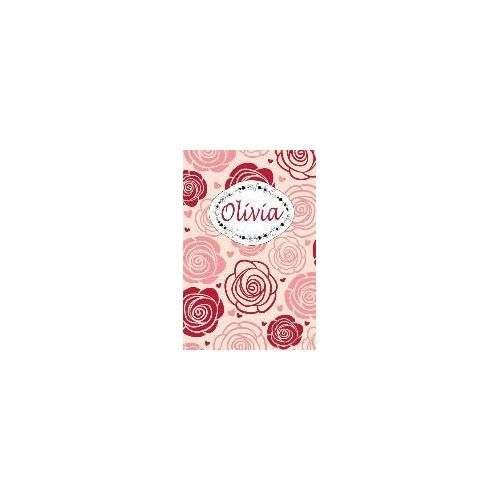
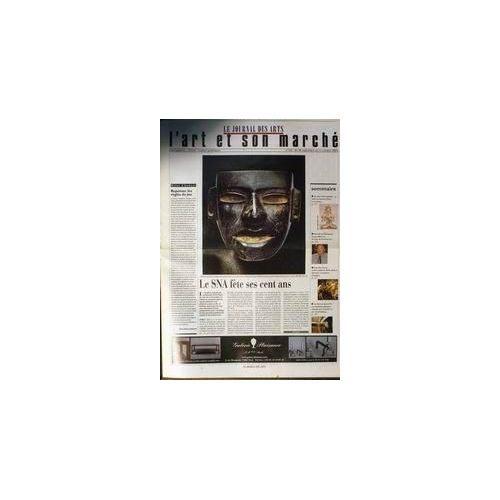
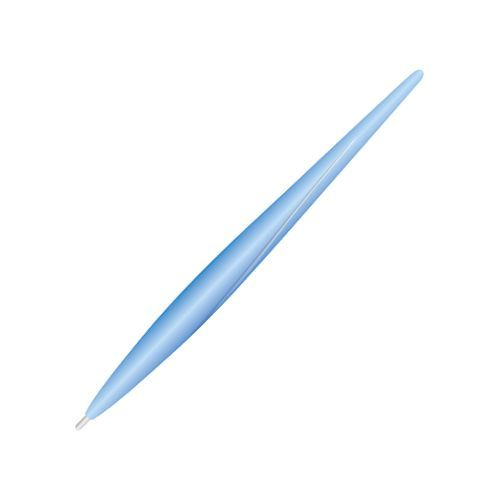
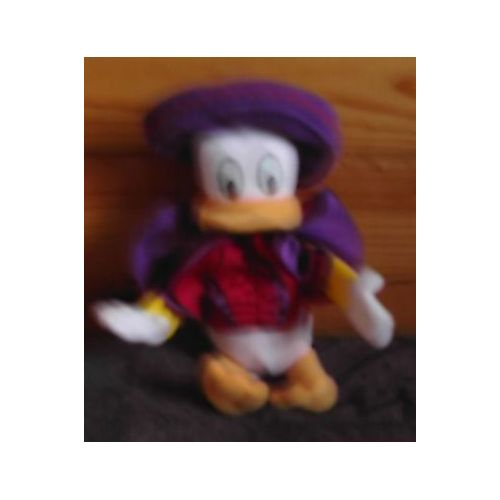
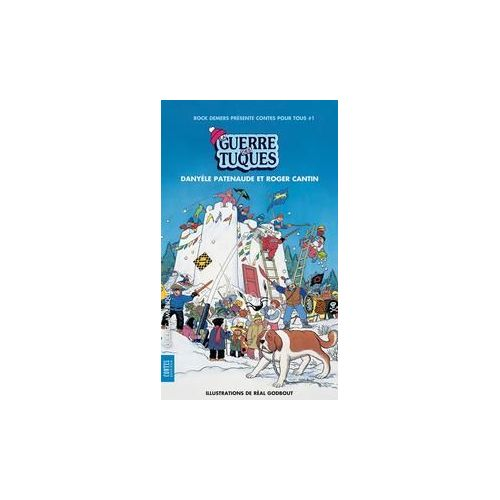
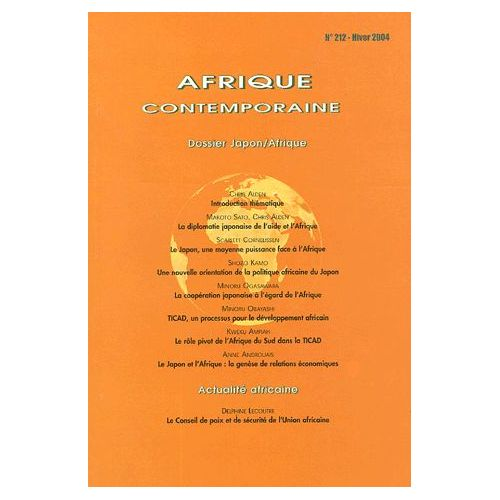
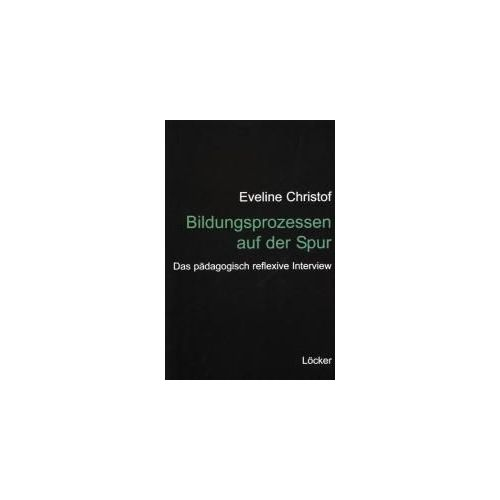
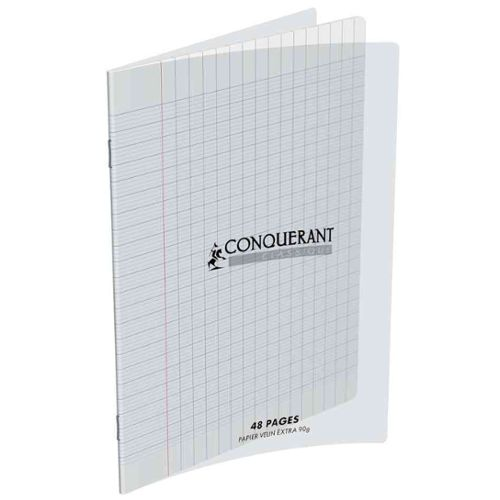
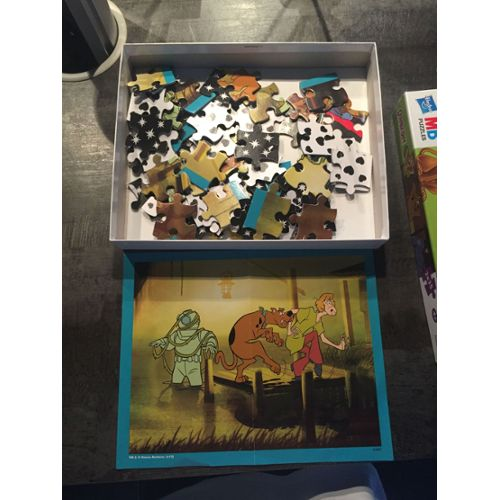
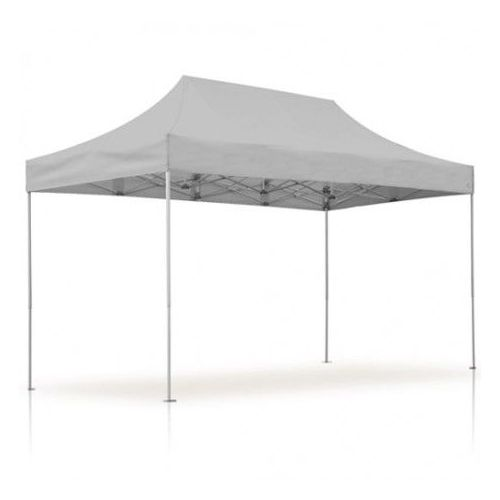
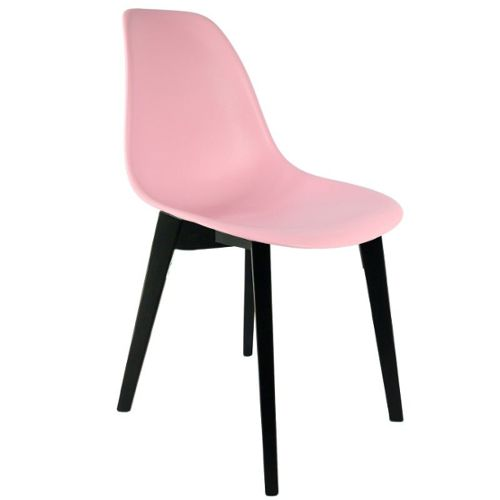
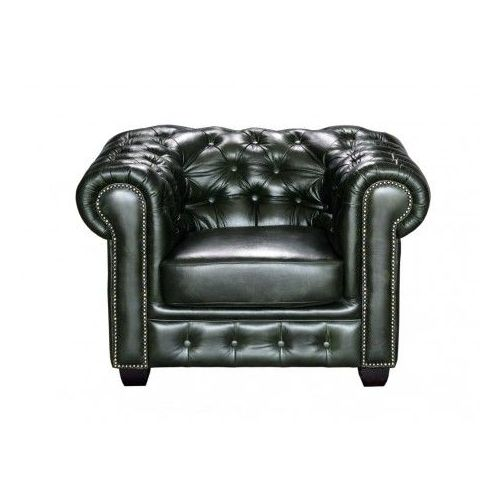
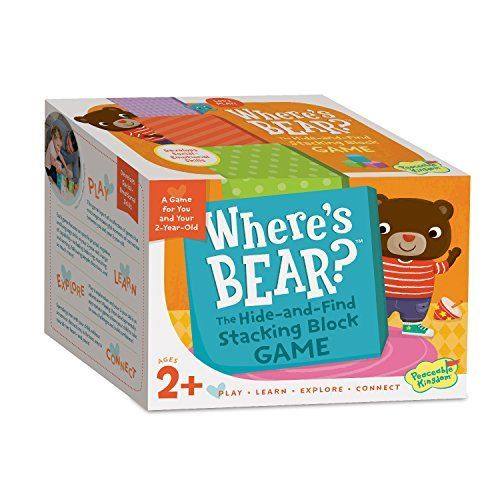
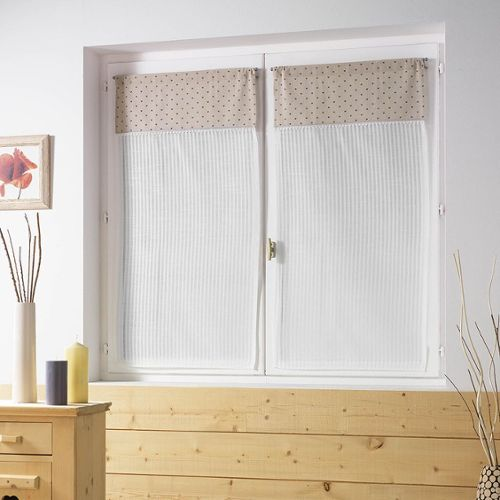
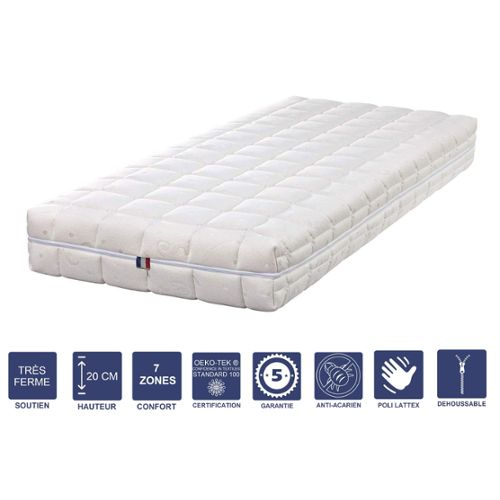
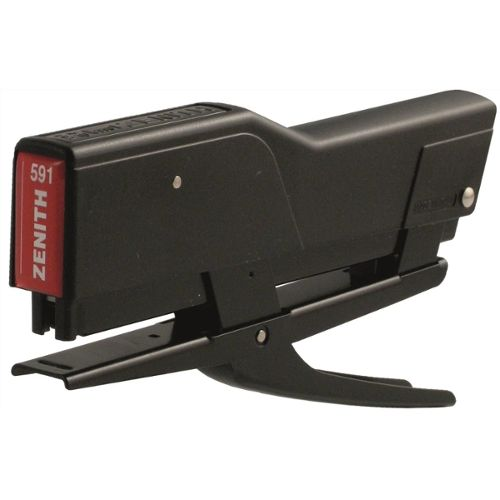
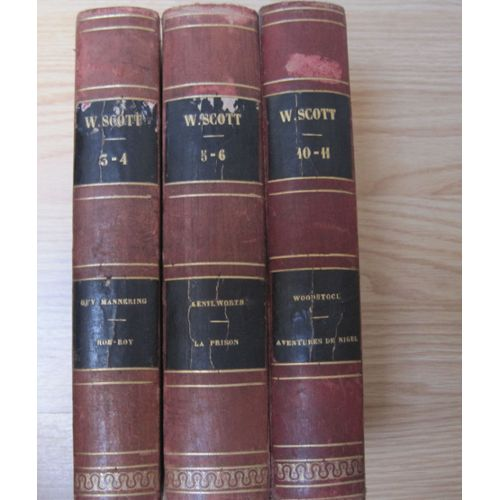
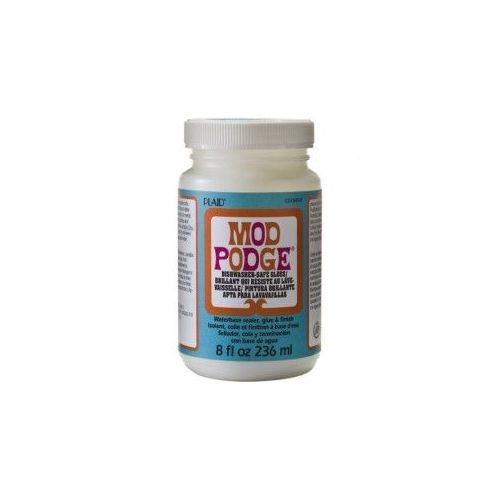
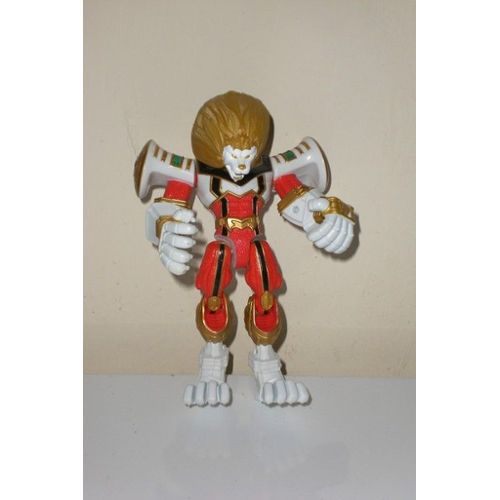
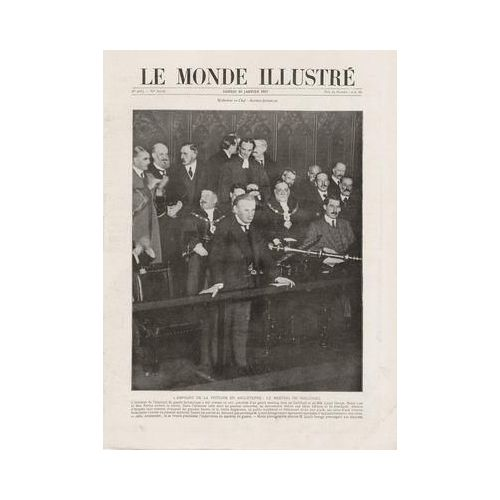

In [12]:
# Préparer un aperçu HTML (DataFrame 'view' + 'style' CSS) des 20 premiers produits :
# scanner les fichiers images, les associe aux 'imageid' du DataFrame via une 'lookup' (dictionnaire),
# convertir les images en HTML pour les afficher dans la table.

IMG_DIR = Path("/workspace/data/images/image_train")
files = list(IMG_DIR.glob("*.jpg"))
pat = re.compile(r"image_(\d+)_product_(\d+)\.jpg$")
lookup = {}
for p in files:
    m = pat.search(p.name)
    if m:
        lookup[m.group(1)] = p

df["image_path"] = df["imageid"].apply(lambda i: lookup.get(str(int(i))))

S = 256
def img_cell(p, size=S):
    if p is None or not Path(p).exists():
        return ""
    b64 = base64.b64encode(Path(p).read_bytes()).decode("ascii")
    return f'<img src="data:image/jpeg;base64,{b64}" style="width:{size}px;height:{size}px;object-fit:contain;display:block;" />'

cols = ["prdtypecode","designation","description","imageid","image_path"]
view = df[cols].head(20).copy()
view["image"] = view["image_path"].apply(lambda p: img_cell(p, S))
view = view.drop(columns=["image_path"])

style = """
<style>
table { table-layout: fixed; width: 100%; }
th, td { text-align: left !important; vertical-align: top !important; }
td:nth-child(1){ width:90px; }
td:nth-child(2){ width:260px; }
td:nth-child(3){ width:520px; word-wrap: break-word; white-space: normal; }
td:nth-child(4){ width:150px; }
td:nth-child(5){ width:270px; }
</style>
"""

display(HTML(style + view.to_html(escape=False, index=True)))


In [85]:
# Fonction pour nettoyer et standardiser les données textuelles:

def nettoyer_texte(text):
    if pd.isna(text): return ""
    s = str(text)
    s = reg.sub(r"<[^>]+>", " ", s)  # Supprime HTML
    s = html.unescape(s)             # Décode entités
    s = s.replace(":", " ")
    s = s.replace("-", " ")
    s = s.replace("////", " ")
    s = unicodedata.normalize("NFC", s)    # Normalise Unicode
    s = reg.sub(r"\s+", " ", s).strip()    # Nettoie espaces et casse
    
    return s


# Sélectionner la description d'un produit spécifique (index 14), lui appliquer la fonction 'nettoyer_texte',
# puis afficher et comparer le texte original et le texte nettoyé pour vérifier le résultat.
index_to_check = 14

original_text = df.loc[index_to_check, 'description']

cleaned_text = nettoyer_texte(original_text)

print(f"--- Index {index_to_check} [text original] ---")
print(original_text)

print("\n" + "="*40 + "\n")

print(f"--- Index {index_to_check} [text cleaned] ---")
print(cleaned_text)


--- Index 14 [text original] ---
MATELAS:<br />Â· Accueil : Ferme .<br />Â· Soutien : Très Ferme .<br />Â· Technologie matelas : Face été &#43; à¢me en Mousse Poli Lattex Dernière Génération Indéformable Très Haute Résilience - Face Hiver 45 cm de Mousse à  Mémoire de Forme Très Haute Densité 60 Kg/m3 &#34; Massante&#34;<br />Â· Épaisseur du matelas : &#43;/- 20 cm.<br />Â· REPOS PLUS SAIN grà¢ce au Traitement Anti-acariens / anti-bactérien / Anti-moisissures.<br />Â· Très Bonne Indépendance de couchage.<br />Â· DORMEZ TRANQUILLE avec la Garantie 5 ans.  Il est Compatible avec les Sommiers Mécaniques et électriques<br />Coutil:<br />Â· Coutil stretch matelassé de 290 gr/m2 de Polyester avec traitement Sanitized. Faces de couchage Réversibles - Déhoussable sur 3 Cà¿tés et Housse Lavable à  30Â° position Lavage à  la main Délicat -<br />Â· SANITIZED : Traitement antibactérien et anti-moisissures diminuant également le développement des odeurs.<br />Structure et garnissage du matelas:<br 

In [61]:
df["description_clean"] = df["description"].apply(nettoyer_texte)


In [62]:
from collections import Counter

def get_word_freq(series, top_n=30):
    all_words = []
    for text in series:
        if isinstance(text, str):
            all_words.extend(text.split())
    return Counter(all_words).most_common(top_n)


In [71]:
top_n = 100

freq_before = get_word_freq(df["description"], top_n=top_n)
freq_after = get_word_freq(df["description_clean"], top_n=top_n)

print("=== Top words BEFORE cleaning ===")
print(freq_before)

print("\n=== Top words AFTER cleaning ===")
print(freq_after)


=== Top words BEFORE cleaning ===
[('de', 367630), ('et', 144565), ('la', 135983), ('à', 109355), ('pour', 81869), ('en', 77839), (':', 75844), ('le', 69047), ('les', 66652), ('x', 66146), ('des', 51713), ('un', 46007), ('est', 44530), ('une', 41327), ('du', 39303), ('vous', 38690), ('-', 38029), ('avec', 37964), ('/>', 33990), ('votre', 31276), ('1', 31031), ('/', 27014), ('<br', 26820), ('dans', 25435), ('ou', 24796), ('sur', 24404), ('cm', 21891), ('pas', 21689), ('peut', 20083), ('plus', 20017), ('que', 18200), ('au', 17206), ('haute', 15849), ('Le', 15725), ('être', 15259), ('2', 15180), ('*', 14890), ('par', 14730), ('sont', 14053), ('ne', 13912), ('qualité', 13605), ('qui', 13452), ('couleur', 13307), ('piscine', 12656), ('La', 12489), ('a', 12268), ('tout', 11778), ('and', 11091), ('the', 10909), ('/><br', 10872), ('Il', 10410), ('Taille:', 10000), ('3', 9736), ('ce', 9691), ('il', 9648), ('plaît', 9627), ('aux', 9415), ('facile', 9342), ('Matériel:', 9261), ('4', 9247), ('sans

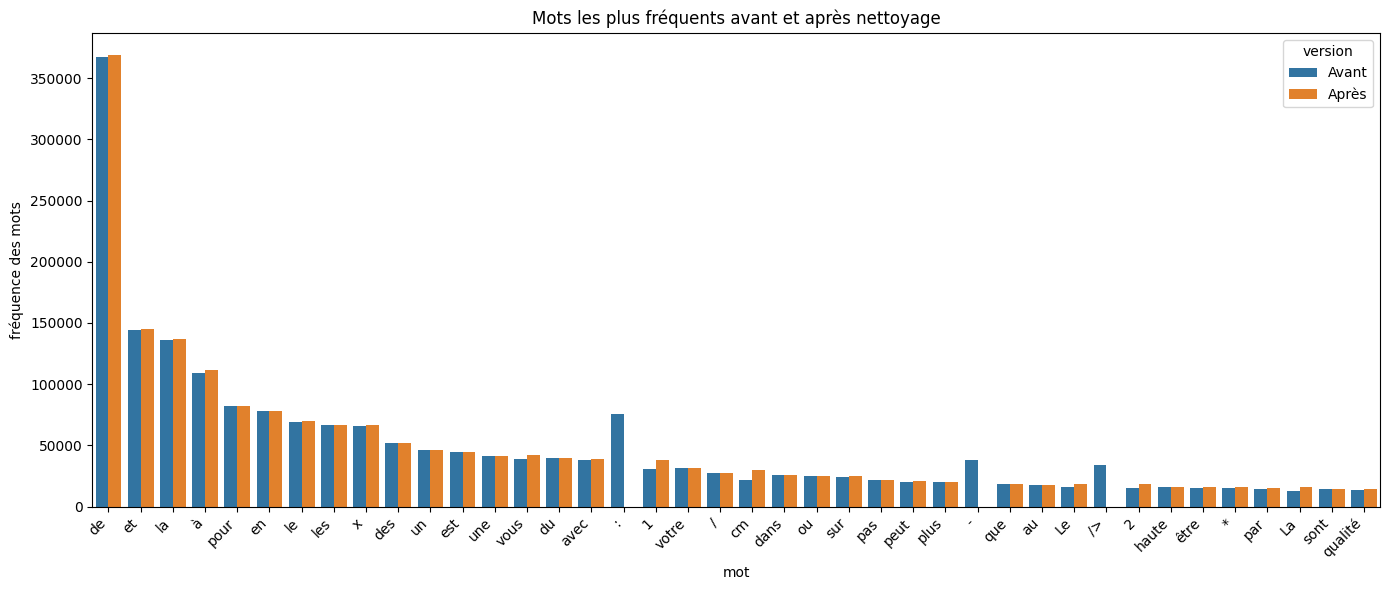

In [68]:
def freq_to_df(freq_list, label):
    df_freq = pd.DataFrame(freq_list, columns=["word", "freq"])
    df_freq["version"] = label
    return df_freq

top_n = 40

df_before = freq_to_df(freq_before, "Avant")
df_after = freq_to_df(freq_after, "Après")

freq_all = pd.concat([df_before, df_after], ignore_index=True)

word_order = (
    freq_all.groupby("word")["freq"]
    .sum()
    .sort_values(ascending=False)
    .index
)[:top_n]

plt.figure(figsize=(14, 6))
sns.barplot(
    data=freq_all,
    x="word",
    y="freq",
    hue="version",
    order=word_order
)

plt.title("Mots les plus fréquents avant et après nettoyage")
plt.xlabel("mot")
plt.ylabel("fréquence des mots")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()